# Inroduction

Les accidents vasculaires cérébraux (AVC) constituent la deuxième cause de mortalité selon l'OMS. Afin de contribuer à la lutte contre cette maladie, nous avons entrepris le développement d'un outil d'aide à la prévention des AVC en utilisant des données médicales et d'algorithmes de machine learning.

# Analyse exploratoire des données (EDA)

In [220]:
import pandas as pd
import copy
# Afficher un aperçu des données
healthcare_data = pd.read_csv("healthcare-dataset-stroke-data.csv", delimiter=",")
healthcare_data.head(3)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [221]:
healthcare_data.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [222]:
# Vérifier l'intégrité des données
healthcare_data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


- Un niveau de glucose dans le sang de 271.74 mg/dL (milligrammes par décilitre) serait considéré comme élevé et pourrait indiquer une hyperglycémie.

- Un niveau de glucose dans le sang de 55.12 mg/dL serait considéré comme relativement bas et pourrait indiquer une hypoglycémie.

- L'âge moyen est de 43 ans, la personne la plus âgée a 82 ans et l'individu le plus jeune a 0.08 ans soit environ 2 jours.

In [223]:
# Vérifier l'intégrité des données
healthcare_data.describe(include=object)

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


<Axes: >

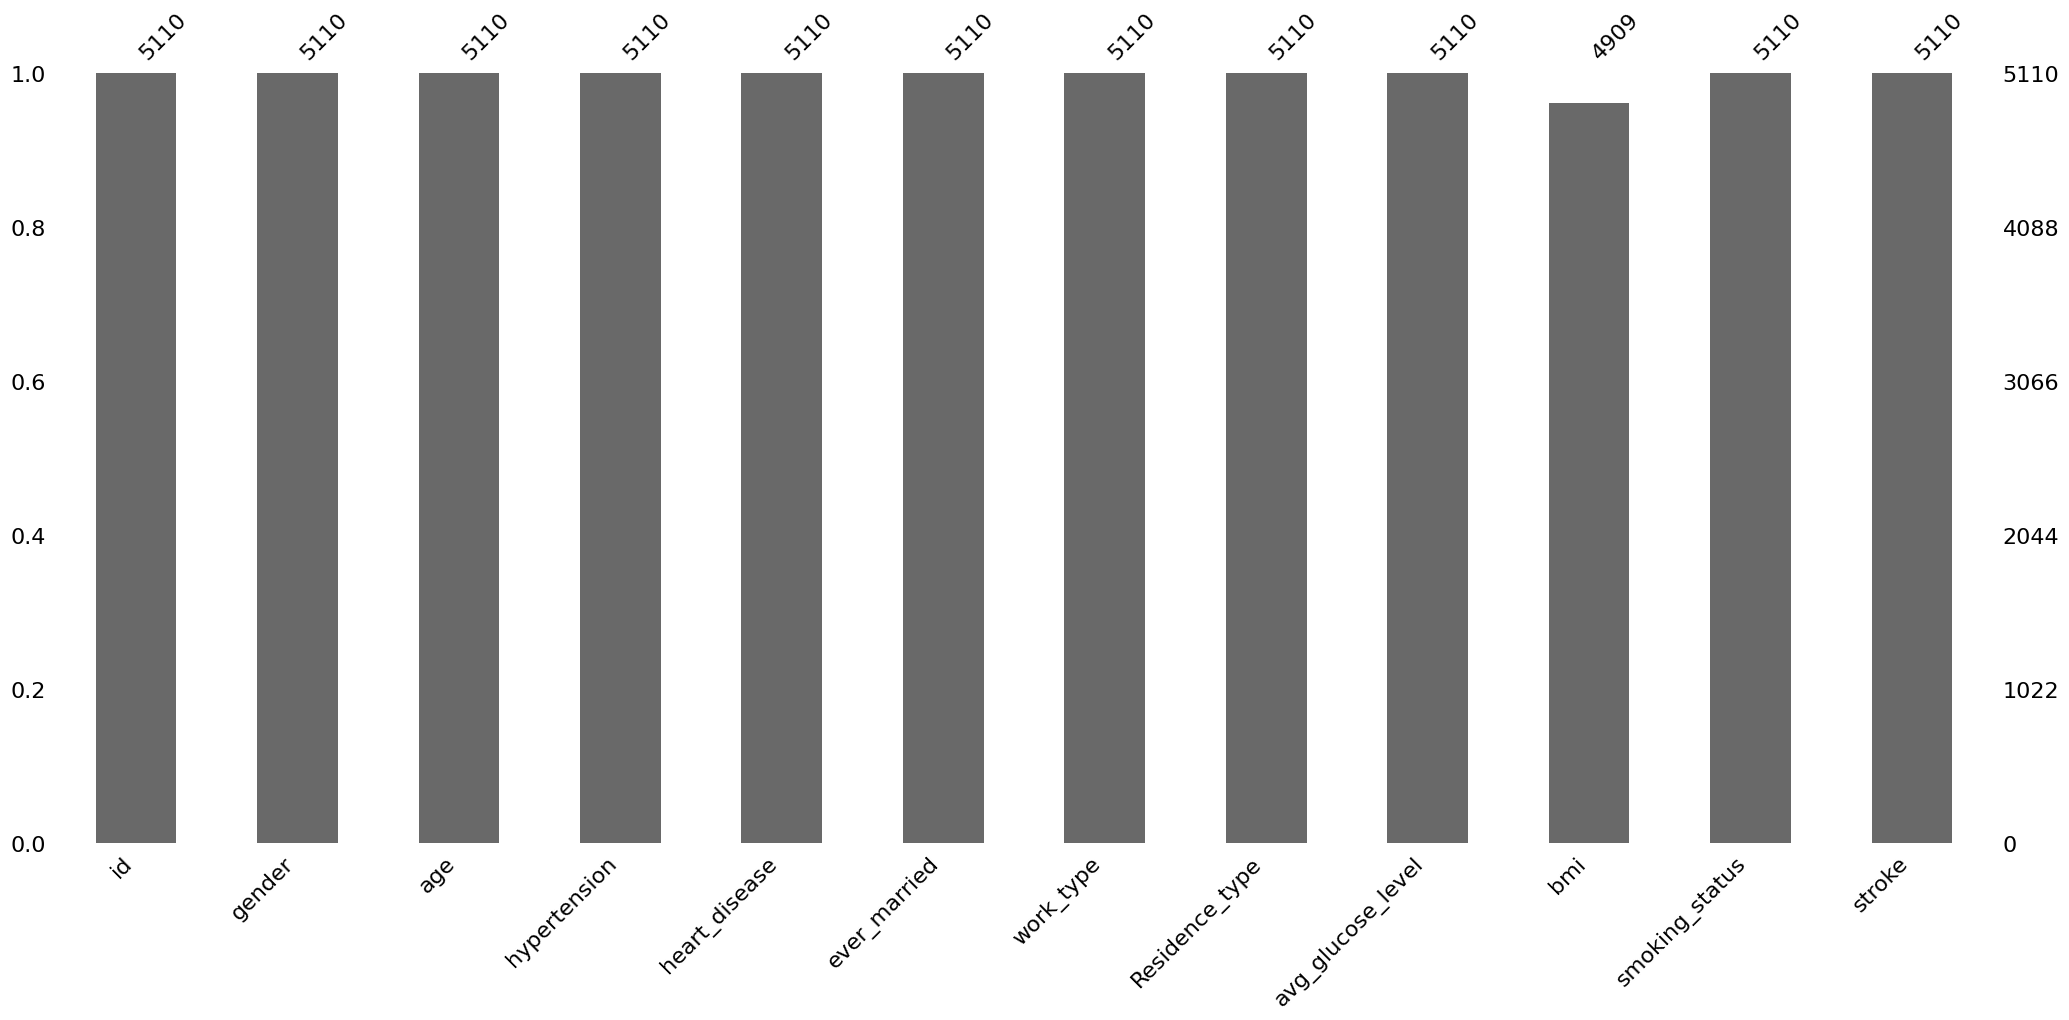

In [224]:
# Recherche de valeurs manquantes
import missingno as msno
msno.bar(healthcare_data)

In [225]:
healthcare_data.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

► On remarque que la colonne "bmi" a 201 valeurs manquantes. On peut se permettre de supprimer ces lignes qui sont peu nombreuses. 

In [226]:
healthcare_data = healthcare_data.dropna(subset=['bmi'])
healthcare_data.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [227]:
healthcare_data['gender'].value_counts()


gender
Female    2897
Male      2011
Other        1
Name: count, dtype: int64

In [228]:
# On enlève la ligne qui contient "Other" pour la colonne genre car non représentative
healthcare_data = healthcare_data[healthcare_data['gender'] != 'Other']
healthcare_data['gender'].value_counts()

gender
Female    2897
Male      2011
Name: count, dtype: int64

In [229]:
# On enlève les lignes correspondantes aux enfants de 10 ans de notre analyse
healthcare_data = healthcare_data[healthcare_data['age'] >= 10]

In [230]:
# Vérification des valeurs uniques pour les colonnes catégorielles
def get_unique(df):
    for column in df.columns:
        if not column in ["id", "age", "avg_glucose_level", "bmi"]: 
            print(column , ":",  df[column].unique())
get_unique(healthcare_data)


gender : ['Male' 'Female']
hypertension : [0 1]
heart_disease : [1 0]
ever_married : ['Yes' 'No']
work_type : ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type : ['Urban' 'Rural']
smoking_status : ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
stroke : [1 0]


In [231]:
initial_healthcare_data = copy.deepcopy(healthcare_data)
print("Nombre d'observations :", initial_healthcare_data.shape[0])
print("Nombre d'AVC :", initial_healthcare_data.loc[initial_healthcare_data.stroke==1].shape[0])

Nombre d'observations : 4449
Nombre d'AVC : 209


► On remarque qu'il y a un nombre faible de cas d'accident vasculaire cérébral (cas positifs) dans notre jeu de données, avec seulement *209* instances d'AVC sur un total de *4449* observations disponibles.
Notre ensemble de données est déséquilibré et cela affecterait les performances du modèle qu'on va utiliser.

**Pas convaincu?**, Nous avons essayé de faire des prédictions en utilisant ce jeu de données tel qu'il est (déséquilibre des données). Vous pouvez trouvé les résultats à la fin de ce notebook dans la section **Annexe**.

**Maintenant**, essayons de faire la data augmentation avec SMOTE pour rétablir l'équilibre de nos données

In [232]:
# labelisation pour la data augmentation
from sklearn.preprocessing import LabelEncoder

def get_annotation(encoder, variable_name):
    print(variable_name)
    for i, category in enumerate(encoder.classes_):
        print(f"{category}: {i}")



label_encoder = LabelEncoder()
healthcare_data['gender'] = label_encoder.fit_transform(healthcare_data['gender'])
get_annotation(label_encoder, "Gender :")
print("\n")

healthcare_data['ever_married'] = label_encoder.fit_transform(healthcare_data['ever_married'])
get_annotation(label_encoder, 'Ever married :')
print("\n")

healthcare_data['work_type'] = label_encoder.fit_transform(healthcare_data['work_type'])
get_annotation(label_encoder, 'Work type :')
print("\n")

healthcare_data['Residence_type'] = label_encoder.fit_transform(healthcare_data['Residence_type'])
get_annotation(label_encoder, 'Residence type :')
print("\n")

healthcare_data['smoking_status'] = label_encoder.fit_transform(healthcare_data['smoking_status'])
get_annotation(label_encoder, 'Smoking status :')



Gender :
Female: 0
Male: 1


Ever married :
No: 0
Yes: 1


Work type :
Govt_job: 0
Never_worked: 1
Private: 2
Self-employed: 3
children: 4


Residence type :
Rural: 0
Urban: 1


Smoking status :
Unknown: 0
formerly smoked: 1
never smoked: 2
smokes: 3


In [233]:
# Data Augmentation

from imblearn.over_sampling import SMOTE


# on separate les features et la variable d'interet "stroke"
X = healthcare_data.drop('stroke', axis=1)
y = healthcare_data['stroke']


# data augmentation SMOTE de la classe minoritaire (stroke =1)
smote = SMOTE(sampling_strategy='minority')
X_augmented, y_augmented = smote.fit_resample(X, y)

# data augmentée
healthcare_data = pd.concat([pd.DataFrame(X_augmented, columns=X.columns),
                            pd.DataFrame(y_augmented, columns=['stroke'])], axis=1)

# vérification
print("Nombre d'observations (aprés SMOTE) :", healthcare_data.shape[0])
print("Nombre d'AVC (aprés SMOTE) :", healthcare_data.loc[healthcare_data.stroke==1].shape[0])

Nombre d'observations (aprés SMOTE) : 8480
Nombre d'AVC (aprés SMOTE) : 4240


In [234]:
healthcare_data.tail(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
8477,15651,1,58.685031,0,0,1,2,1,108.666855,36.279925,1,1
8478,12364,0,72.087437,0,0,1,2,0,78.640632,28.191720,2,1
8479,17367,1,67.738253,0,0,0,2,0,99.303238,30.205914,1,1


► On remarque que nombre d'observations total a augmenté après l'application de SMOTE et que le nombre d'observations pour la classe minoritaire (stroke = 1) a augmenté pour se rapprocher du nombre d'observations pour la classe majoritaire (stroke = 0), cela confirme qu'on a obtenu plus de données et que les classes ont été rééquilibrées avec cette méthode.

# Etude de correlation

Bien qu'on a tendance à l'utiliser souvent, la corrélation de Pearson, qui est couramment utilisée pour mesurer la relation linéaire entre deux variables continues, n'est pas appropriée pour mesurer la corrélation entre une variable continue (age ou avg_glucose_level ou bien bmi) et une variable binaire (stroke). 

Dans ce cas, nous pouvons utiliser le coefficient de corrélation de rang de Spearman.

In [235]:

from scipy.stats import spearmanr

# Calcul de la correlation entre bmi et stroke
print("Calcul de la correlation entre bmi et stroke")
correlation, p_value = spearmanr(healthcare_data['bmi'], healthcare_data['stroke'])
print("Coefficient de corrélation de rang de Spearman:", correlation)
print("p-value:", p_value)


Calcul de la correlation entre bmi et stroke
Coefficient de corrélation de rang de Spearman: 0.09884402144553764
p-value: 7.290646927427838e-20


► Le coefficient de corrélation de rang de Spearman est de 0.09, indiquant une corrélation très faible entre le bmi et l'AVC. Cependant, la p-value est très faible, ce qui signifie que cette corrélation est statistiquement significative mais faible.

In [236]:
# Calcul de la correlation entre age et stroke
print("Calcul de la correlation entre age et stroke")
correlation, p_value = spearmanr(healthcare_data['age'], healthcare_data['stroke'])
print("Coefficient de corrélation de rang de Spearman:", correlation)
print("p-value:", p_value)

Calcul de la correlation entre age et stroke
Coefficient de corrélation de rang de Spearman: 0.5561125668663167
p-value: 0.0


► Le coefficient de corrélation de rang de Spearman est dans les environs 0.5, ce qui suggère une corrélation modérée à forte entre les variables. Avec une p-value de 0.0, cette corrélation est statistiquement significative, indiquant une relation significative entre les deux variables age et AVC.

In [237]:
# calcul de la correlation entre avg_glucose_level et stroke
print("Calcul de la correlation entre avg_glucose_level et stroke")
correlation, p_value = spearmanr(healthcare_data['avg_glucose_level'], healthcare_data['stroke'])
print("Coefficient de corrélation de rang de Spearman:", correlation)
print("p-value:", p_value)

Calcul de la correlation entre avg_glucose_level et stroke
Coefficient de corrélation de rang de Spearman: 0.3167851079120274
p-value: 5.607155137641411e-197


► Le coefficient de corrélation de rang de Spearman est de 0.3, ce qui suggère une petite corrélation entre les variables avg_glucose_level et stroke. Avec une très faible p-value, cette corrélation est statistiquement significative, indiquant une relation significative entre les deux variables taux moyen de glucose et AVC.

Le test de contingence (ou bien test du chi-deux) est utilisé pour évaluer l'indépendance entre deux variables catégorielles. Par exemple, heart disease et stroke, hypertension et stroke, smoking status et stroke...etc

In [238]:

from scipy.stats import chi2_contingency
import numpy as np
# calcul de la correlation entre heart disease (maladie cardiaque) et stroke (AVC)
print("Correlation entre heart disease et stroke:")


# calcul du tableau de contingence
contingency_table = pd.crosstab(healthcare_data['heart_disease'], healthcare_data['stroke'])

#calcul du coeff de contingence
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Coefficient de contingence:", np.sqrt(chi2 / (len(healthcare_data['heart_disease']) * min(len(healthcare_data['stroke']), len(healthcare_data['heart_disease'])))))



Correlation entre heart disease et stroke:
Coefficient de contingence: 7.947652352236596e-05


► Le coefficient de contingence est très faible, ce qui suggère une association très faible entre le statut de maladie cardiaque et l'AVC.

► Cela peut sembler contre-intuitif, il est possible que dans nos données, il y ait peu de cas où les personnes ayant une maladie cardiaque ont également eu un AVC, ou que d'autres facteurs influencent cette association.

In [239]:
#calcul de la correlation entre hypertension (hypertension) et stroke (AVC)
print("Correlation entre hypertension et stroke:")


# calcul du tableau de contingence
contingency_table = pd.crosstab(healthcare_data['hypertension'], healthcare_data['stroke'])

#calcul du coeff de contingence
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Coefficient de contingence:", np.sqrt(chi2 / (len(healthcare_data['hypertension']) * min(len(healthcare_data['stroke']), len(healthcare_data['hypertension'])))))

Correlation entre hypertension et stroke:
Coefficient de contingence: 6.57892197613962e-05


► Le coefficient de contingence est très faible, ce qui suggère une association très faible entre l'hypertension et l'AVC.

► Encore une fois, cela peut sembler contre-intuitif, il est possible qu'il y ait peu de cas où les personnes hypertendues ont également eu un AVC dans nos données, ou que d'autres facteurs influencent cette association.

In [240]:
# calcul de la correlation entre smoking_status (smoking_status) et stroke (AVC)
print("Correlation entre smoking_status et stroke:")
# calcul du tableau de contingence
contingency_table = pd.crosstab(healthcare_data['smoking_status'], healthcare_data['stroke'])

#calcul du coeff de contingence
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Coefficient de contingence:", np.sqrt(chi2 / (len(healthcare_data['smoking_status']) * min(len(healthcare_data['stroke']), len(healthcare_data['smoking_status'])))))

Correlation entre smoking_status et stroke:
Coefficient de contingence: 0.0032338800575020627


► Le coefficient de contingence est très faible, ce qui suggère une association très faible entre fumer et AVC.

► Il est possible qu' il y ait peu de cas où fumer a un impact sur l'AVC dans nos données, ou que d'autres facteurs influencent cette association.

↔ A travers cette analyse, on constate qu'il existe une corrélation entre la variable à expliquer 'stroke', et la variable explicative 'âge', mais aussi une corrélation avec 'avg_glucose_level' qui est moins prononcée mais qu'on peut tout de meme considérer. 

Cependant, aucune corrélation "significative" n'a été trouvée avec d'autres variables telles que l'hypertension, les maladies cardiaques ou encore le statut de tabagisme. Une des raisons est que ces paramétres n'ont pas d'impact sur l'AVC dans le jeu données qu'on a.

Rappelons que les AVC sont aussi causés par la consommation excessive d'alcool et peuvent aussi avoir une origine génétique. 

# Modélisation

 Supposons que nous choisissons l'âge comme la seule caractéristique à utiliser pour prédire les AVC (variable indépendante/explicative). 

In [241]:
# Normalisation des données
from sklearn.preprocessing import StandardScaler

X = healthcare_data[['age']]
y = healthcare_data['stroke']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [242]:
from sklearn.model_selection import train_test_split
# on va diviser les données en ensembles d'entraînement (70%) et de test (30%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

Commençons par la *régression logistique*

La régression logistique est couramment utilisée dans les cas où on doit prédire une variable binaire, càd une variable qui a seulement deux valeurs possibles comme pour "stroke" (variable dépendante) où on a deux possibilité (1 ou bien 0).

La régression logistique utilise la fonction logistique (sigmoïde), pour modéliser la relation entre la variable indépendante (l'age dans notre cas) et la probabilité de la variable dépendante (stroke).

In [243]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Modélisation avec la regression logistique
model =  LogisticRegression()

# cross-validation en 5 fold
scores = cross_val_score(model, X_train, y_train, cv=5)
print("accuracy moyenne:", scores.mean())

accuracy moyenne: 0.7634770904779329


Les résultats de la cross validation indiquent que la régression logistique présente une précision moyenne d'environ 76% sur différents sous-ensembles de données training, on peut estimer que c'est acceptable et on peut dire qu'il généralise assez bien.

              precision    recall  f1-score   support

           0       0.79      0.70      0.74      1260
           1       0.74      0.81      0.77      1284

    accuracy                           0.76      2544
   macro avg       0.76      0.76      0.76      2544
weighted avg       0.76      0.76      0.76      2544

Matrice de confusion :
[[ 884  376]
 [ 240 1044]]


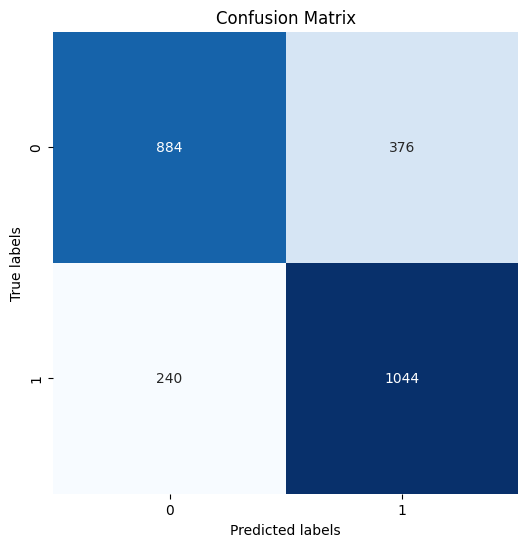

In [244]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# affichage des metrics
report = classification_report(y_test, predictions)
print(report)


# calcul de la matrice de confusion

conf_matrix = confusion_matrix(y_test, predictions)
print("Matrice de confusion :")
print(conf_matrix)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Dans le domaine de la santé, la métrique la plus importante pour détecter la plupart des cas correctement est le Recall qui mesure la proportion de cas positifs réels (dans ce contexte, les cas d'AVC) qui sont correctement identifiés par le modèle.

Le Recall pour la classe 0 (non-AVC) est de 0,7. Cela signifie que le modèle a correctement identifié 70 % des vrais cas de non-AVC.

Un faux négatif pourrait signifier qu'un patient présentant des symptômes d'AVC ne reçoit pas le traitement nécessaire à temps, ce qui pourrait entraîner des conséquences graves, voire mortelles. Par conséquent, en plus de minimiser les faux positifs, il est encore **plus important** d'optimiser le modèle pour réduire les faux négatifs, afin de garantir une détection précise et rapide des cas d'AVC. Dans notre cas :

Le Recall pour la classe 1 (AVC) est de 0,8. Cela signifie que le modèle a correctement identifié 80 % des vrais cas d'AVC.

La matrice de confusion met en évidence nos succès et nos lacunes dans la classification des données. Bien que notre modèle ait correctement identifié un nombre considérable d'exemples, il a également manqué certains cas positifs (faux négatifs) et en a incorrectement classé d'autres comme positifs (faux positifs). 

Essayons un deuxième modèle pour réduire ces erreurs, le SVM. Ce modèle est initialisé avec les paramètres par défaut.

In [245]:
from sklearn.svm import SVC

model = SVC()

# cross-validation en 5 fold
scores = cross_val_score(model, X_train, y_train, cv=5)
print("accuracy moyenne:", scores.mean())

accuracy moyenne: 0.7654991362657749


On trouve à peu près le meme résultat que celui de la cross validation sur la régression logistique. On peut estimer que c'est raisonnable et que le modèle généralise assez bien.

              precision    recall  f1-score   support

           0       0.84      0.63      0.72      1260
           1       0.71      0.88      0.79      1284

    accuracy                           0.76      2544
   macro avg       0.78      0.76      0.76      2544
weighted avg       0.78      0.76      0.76      2544

Matrice de confusion :
[[ 798  462]
 [ 149 1135]]


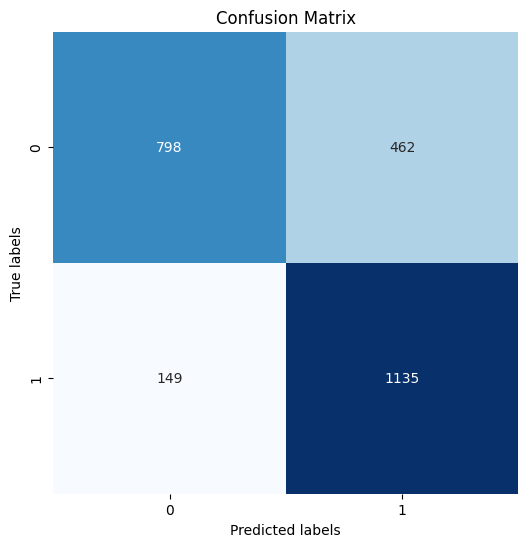

In [246]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# afficher les métriques
report = classification_report(y_test, predictions)
print(report)

# calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, predictions)
print("Matrice de confusion :")
print(conf_matrix)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Avec un Recall de 88%, le modèle semble être capable de détecter de manière fiable la majorité des cas d'AVC chez les patients et on le voit bien  à travers la matrice de confusion : on a moins de cas de faux négatifs par rapport au premier modèle utilisé. C'est donc un modèle qui est déjà meilleur que celui de la régression logistique du moins dans la detection des vrais cas d'AVC.

Les autres valeurs des métriques sont moins bonnes avec notamment 77% en accuracy générale. 

Passons à l'utilisation du Random Forest pour voir si on peut faire mieux!

In [247]:
from sklearn.ensemble import RandomForestClassifier

# RF avec 100 arbres par defaut 
model = RandomForestClassifier()

# cross-validation en 5 fold
scores = cross_val_score(model, X_train, y_train, cv=5)
print("accuracy moyenne:", scores.mean())

accuracy moyenne: 0.9514836656369934


Les résultats de la cross validation indiquent que le Random Forest présente une précision moyenne d'environ 95% sur différents sous-ensembles de données training, suggérant sa capacité à généraliser efficacement aux données non vues.

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1260
           1       1.00      0.89      0.94      1284

    accuracy                           0.95      2544
   macro avg       0.95      0.95      0.95      2544
weighted avg       0.95      0.95      0.95      2544

Matrice de confusion :
[[1260    0]
 [ 135 1149]]


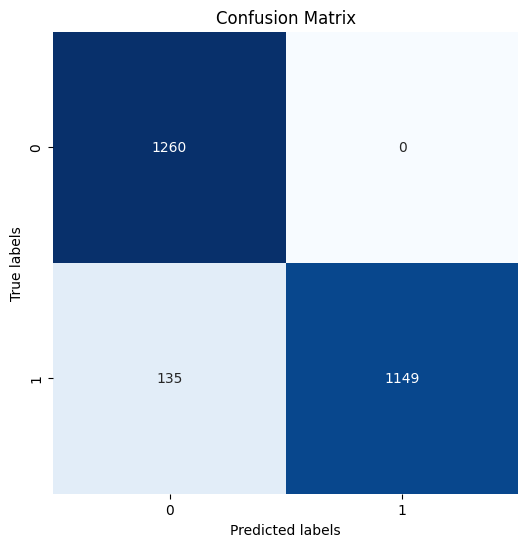

In [248]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# afficher les métriques
report = classification_report(y_test, predictions)
print(report)

# calcul de la matrice de confusion

conf_matrix = confusion_matrix(y_test, predictions)
print("Matrice de confusion :")
print(conf_matrix)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Avec un Recall de 91% (classe 1), le modèle semble être capable de détecter de manière fiable la présence d'AVC chez les patients.
Le Recall pour les patients ayant eu un AVC (classe 1) est de 0.91, ce qui signifie que le modèle a réussi à identifier correctement 91% des patients qui ont eu un AVC parmi tous ceux qui en ont effectivement eu un. A travers la matrice de confusion, on remarque qu'on a moins de cas de faux négatifs que ceux rapportés par le SVM et par la régression logistique. 

On constate également que le Recall pour la classe 0 (non-AVC) est de 100%. Cela signifie que notre modèle a réussi à capturer tous les vrais cas de non-AVC parmi tous les cas réels de cette classe, ce qui se traduit par aucun faux positif. Ceci est un plus, cela nous évitera d'entraîner de l'anxiété et de la frayeur chez le patient en l'identifiant à tort comme présentant un risque d'AVC alors qu'il n'en a pas.

=> Ce modèle RF est plus efficace que celui de la régression logistique.

Après avoir comparé les performances des trois modèles testés (Régression Logistique, SVM, et Random Forest), nous avons constaté que le modèle Random Forest surpassait les autres en termes de performances générales, en particulier en ce qui concerne le **Recall de la classe 1**, ce qui est crucial dans le domaine médical. En conséquence, nous avons choisi de retenir ce dernier comme étant le plus approprié pour notre tâche de classification.

 Maintenant, supposons que nous choisissons **l'âge + le taux moyen de glucose** comme caractéristiques à utiliser pour prédire les AVC (variables indépendantes/explicatives).

In [249]:
# On ajoute le taux moyen de glucose pour expliquer les AVC
X = healthcare_data[['age', 'avg_glucose_level']]
y = healthcare_data['stroke']
# On normalise nos données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# on divise les données en ensembles d'entraînement (70%) et de test (30%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [250]:
## On va utiliser le meilleur model qui est le RF cette fois-ci

# RF avec 100 arbres par defaut 
model = RandomForestClassifier()

# cross-validation en 5 fold
scores = cross_val_score(model, X_train, y_train, cv=5)
print("accuracy moyenne:", scores.mean())

accuracy moyenne: 0.8473723474565933


Les résultats de la cross validation indiquent que le Random Forest présente une précision moyenne de 85% sur différents sous-ensembles de données d'entrainement, suggérant sa capacité à généraliser efficacement aux données non vues. Néanmoins, c'est une accuracy plus faible que celle qu'on avait trouvé avec seulement l'age comme feature. 
Testons notre model RF.

In [251]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# afficher les métriques
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1260
           1       0.85      0.86      0.85      1284

    accuracy                           0.85      2544
   macro avg       0.85      0.85      0.85      2544
weighted avg       0.85      0.85      0.85      2544



Les performances du modèle sont remarquables, avec un Recall de 85% (tout comme les autres métriques), ce qui suggère une capacité fiable à détecter la présence d'AVC chez les patients. Cependant, les résultats sont encore plus concluants (Recall classe 1= 91%) lorsqu'on se limite à utiliser uniquement l'âge comme caractéristique.

Ces constats semblent cohérents avec les résultats de corrélation et de cross validation. En effet, l'ajout de la variable 'avg_glucose_level' semble avoir un impact négatif sur les performances globales du modèle. 

Cette observation peut se confirmer davantage lorsqu'on se restreint à cette caractéristique pour prédire les AVC. Let's see!:

In [252]:
# On utilise seulement le taux moyen de glucose pour expliquer les AVC
X = healthcare_data[['avg_glucose_level']]
y = healthcare_data['stroke']
# On normalise les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# on divise les données en ensembles d'entraînement (70%) et de test (30%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [253]:
## On va utiliser le meilleur model qui est le RF cette fois-ci
# RF avec 100 arbres par defaut 
model = RandomForestClassifier()

# cross-validation en 5 fold
scores = cross_val_score(model, X_train, y_train, cv=5)
print("accuracy moyenne:", scores.mean())

accuracy moyenne: 0.5825444844400194


In [254]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# afficher les métriques
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.57      0.56      0.57      1260
           1       0.58      0.59      0.58      1284

    accuracy                           0.57      2544
   macro avg       0.57      0.57      0.57      2544
weighted avg       0.57      0.57      0.57      2544



Les résultats montrent que le modèle n'est pas performant lorsqu'il utilise uniquement cette caractéristique "avg_glucose_level". En effet, il parvient à prédire correctement seulement la moitié du temps.
Il semble que l'utilisation du Random Forest avec uniquement l'âge comme caractéristique soit la meilleure approche pour notre étude.

# Conclusion

En conclusion, ce projet visant à prédire les patients atteints d'AVC a abouti à des résultats encourageants. En utilisant un modèle de classification Random Forest, nous avons pu surpasser les performances des modèles de régression logistique et de SVM. 
Ce modèle présente un bon Recall, ce qui limite les faux négatifs, et offre de bonnes valeurs de métriques globales. 

Notamment, il est remarquable qu'une seule variable, l'âge des patients, ait été utilisée dans la détection. Bien que l'âge émerge comme un prédicteur significatif dans notre modèle, d'autres variables telles que le taux de glucose dans le sang ou les maladies cardiaques ne semblent pas contribuer à la prédiction de manière significative. Alors que ces deux dernières peuvent ne pas être fortement corrélées avec l'AVC dans notre ensemble de données, il est possible qu'elles jouent toujours un rôle dans la prédiction de l'AVC, mais la relation est plus complexe ou indirecte.

En somme, ces résultats prometteurs offrent un potentiel significatif pour l'amélioration des stratégies de prévention et de gestion des AVC, soulignant ainsi l'utilité des techniques de modélisation avancées dans le domaine médical.

# Annexe

In [255]:
print(initial_healthcare_data.shape)
df_final = initial_healthcare_data

(4449, 12)


In [256]:
# correlation entre bmi et stroke en utilisant Spearman
print("Calcul de la correlation entre bmi et stroke")
correlation, p_value = spearmanr(df_final['bmi'], df_final['stroke'])
print("Coefficient de corrélation de rang de Spearman:", correlation)
print("p-value:", p_value)

Calcul de la correlation entre bmi et stroke
Coefficient de corrélation de rang de Spearman: 0.027898930183348367
p-value: 0.06278360000856374


In [257]:
# correlation entre age et stroke
print("Calcul de la correlation entre age et stroke")
correlation, p_value = spearmanr(df_final['age'], df_final['stroke'])
print("Coefficient de corrélation de rang de Spearman:", correlation)
print("p-value:", p_value)

Calcul de la correlation entre age et stroke
Coefficient de corrélation de rang de Spearman: 0.23332535274937413
p-value: 4.489535326932322e-56


In [258]:
#correlation entre avg_glucose_level et stroke
print("Calcul de la correlation entre avg_glucose_level et stroke")
correlation, p_value = spearmanr(df_final['avg_glucose_level'], df_final['stroke'])
print("Coefficient de corrélation de rang de Spearman:", correlation)
print("p-value:", p_value)

Calcul de la correlation entre avg_glucose_level et stroke
Coefficient de corrélation de rang de Spearman: 0.08870895245551212
p-value: 3.0854716821449725e-09


In [259]:
# Test de khi2

# calcul de la correlation entre heart disease (maladie cardiaque) et stroke (AVC)
print("Correlation entre heart disease et stroke:")


# calcul du tableau de contingence
contingency_table = pd.crosstab(df_final['heart_disease'], df_final['stroke'])

#calcul du coeff de contingence
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Coefficient de contingence:", np.sqrt(chi2 / (len(df_final['heart_disease']) * min(len(df_final['stroke']), len(df_final['heart_disease'])))))

Correlation entre heart disease et stroke:
Coefficient de contingence: 0.0019754937789457513


In [260]:
#calcul de la correlation entre hypertension (hypertension) et stroke (AVC)
print("Correlation entre hypertension et stroke:")


# calcul du tableau de contingence
contingency_table = pd.crosstab(df_final['hypertension'], df_final['stroke'])

#calcul du coeff de contingence
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Coefficient de contingence:", np.sqrt(chi2 / (len(df_final['hypertension']) * min(len(df_final['stroke']), len(df_final['hypertension'])))))

Correlation entre hypertension et stroke:
Coefficient de contingence: 0.0020216996072913956


In [261]:
# calcul de la correlation entre smoking_status (smoking_status) et stroke (AVC)
print("Correlation entre smoking_status et stroke:")
# calcul du tableau de contingence
contingency_table = pd.crosstab(df_final['smoking_status'], df_final['stroke'])

#calcul du coeff de contingence
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Coefficient de contingence:", np.sqrt(chi2 / (len(df_final['smoking_status']) * min(len(df_final['stroke']), len(df_final['smoking_status'])))))

Correlation entre smoking_status et stroke:
Coefficient de contingence: 0.0009280314668862633


Au vue des résultats des différents tests effectués, les coefficients de corrélation entre les variables explicatives et la variable expliquée ne sont pas élevés. 

Par contre, elles sont toutes positives, ce qui montre qu'elles évoluent parallèlement avec la variable stroke. Nous choisissons les variables 'age' et 'avg_glucose_level' dont leur coeffiscient de corrélation est acceptable par rapport aux autres pour faire du machine learning.

In [262]:
#Sélection de la variable explicative hypertension
X = df_final[['age']]

# Sélection de la variable expliquée 
y = df_final['stroke']

# Séparation de la donnée en set d'entraînement et de validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [263]:
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# affichage des metrics
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1266
           1       0.00      0.00      0.00        69

    accuracy                           0.95      1335
   macro avg       0.47      0.50      0.49      1335
weighted avg       0.90      0.95      0.92      1335



Compte tenu du rapport de classification , On voit que les résultats ne sont pas du tout parlants.

Quand on regarde le Recall, on voit que le modèle prédit à 100% les non malades et n'arrive pas du tout à prédire les malades, ce qui est prévisible vu le déséquilibre du jeu de donnée qui est constitué pratiquement que des patients non malades.